In [1]:
from operator import iadd
from functools import reduce
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Display all rows
pd.set_option('display.max_rows', None)

In [3]:
# Get data up to 5-25-2020
df = pd.read_json('http://localhost:5000/api/get/allentries')

In [4]:
# Clean data

# Remove prison visit survey responses
df = df[df['format'] != 'Prison visit']

# Remove entries with no tags
df = df[[bool(tags) for tags in df['tags']]]

# Remove entries with no date entered, and limit to 2019
df = df[[(date is not None and date >= '2019-01-01' and date < '2020-01-01') for date in df['date_received']]]

# Keep relevant columns
df = df.filter(['eid', 'date_received', 'facility', 'tags'])

# Format dates to Python datetime
df['date_received'] = pd.to_datetime(df['date_received'])

In [5]:
# Total number of entries
n = len(df.index)
print('Total entries: ' + str(n))

Total entries: 1958


In [6]:
# Categories summary, 2019
# count refers to # of letters with this tag, percentage refers to % of letters with this tag
categories = df['tags'].apply(lambda tags: pd.Series([tag['name'] for tag in tags]).value_counts()).sum()
categories = categories.to_frame()
categories.columns = ['count']
categories['percentage'] = categories['count'] * 100 / n
categories.sort_values(by='count', ascending=False)

,count,percentage
Operations,939.0,47.957099
Health & Well-being,307.0,15.679265
Procedural,298.0,15.219612
Interpersonal,269.0,13.738509
Services,122.0,6.230848
Economics,28.0,1.430031


In [7]:
# Issues summary, 2019
# count refers to # of letters with this tag, percentage refers to % of letters with this tag
issues = df['tags'].apply(lambda tags: pd.Series(reduce(iadd, (tag['subtags'] for tag in tags))).value_counts()).sum()
issues = issues.to_frame()
issues.columns = ['count']
issues['percentage'] = issues['count'] * 100 / n
issues.sort_values(by='count', ascending=False)

,count,percentage
Survey response,801.0,40.909091
Medical,241.0,12.308478
Parole,206.0,10.520940
Staff abuse,118.0,6.026558
SvP,73.0,3.728294
Discipline,53.0,2.706844
Programs,50.0,2.553626
Grievance,32.0,1.634321
PREA,29.0,1.481103
Request for interview,25.0,1.276813


In [8]:
# Entries tagged 'Grievance', 2019
issues.loc['Grievance']

count         32.000000
percentage     1.634321
Name: Grievance, dtype: float64

In [9]:
# Flatten
df = (pd.concat({i: pd.json_normalize(x) for i, x in df.pop('tags').items()})
        .reset_index(level=1, drop=True)
        .join(df)
        .reset_index()
     )

In [10]:
# Format categories plot
df_cat = df[:]
df_cat['date_received'] = pd.to_datetime(df_cat['date_received'])
df_cat.index = df_cat['date_received']
df_cat = (df_cat.groupby([pd.Grouper(freq='M'), 'name'])
                .count()
                .filter(['name', 'eid'])
                .rename(columns={'eid': 'count'})
                .reset_index()
         )

# Pad zeroes
n_months = df_cat['date_received'].unique()
n_categs = df_cat['name'].unique()
n_idx = pd.MultiIndex.from_product((n_months, n_categs), names=['date_received', 'name'])
df_cat = df_cat.set_index(['date_received', 'name']).reindex(n_idx, fill_value=0).reset_index()

# Normalize
df_cat_sum = df_cat.groupby('date_received').sum()
df_cat_sum.columns = ['sum']
df_cat = df_cat.join(df_cat_sum, on='date_received')
df_cat['percentage'] = df_cat['count'] / df_cat['sum']

# Remove months with less than 5 entries
df_cat = df_cat[df_cat['sum'] >= 5]

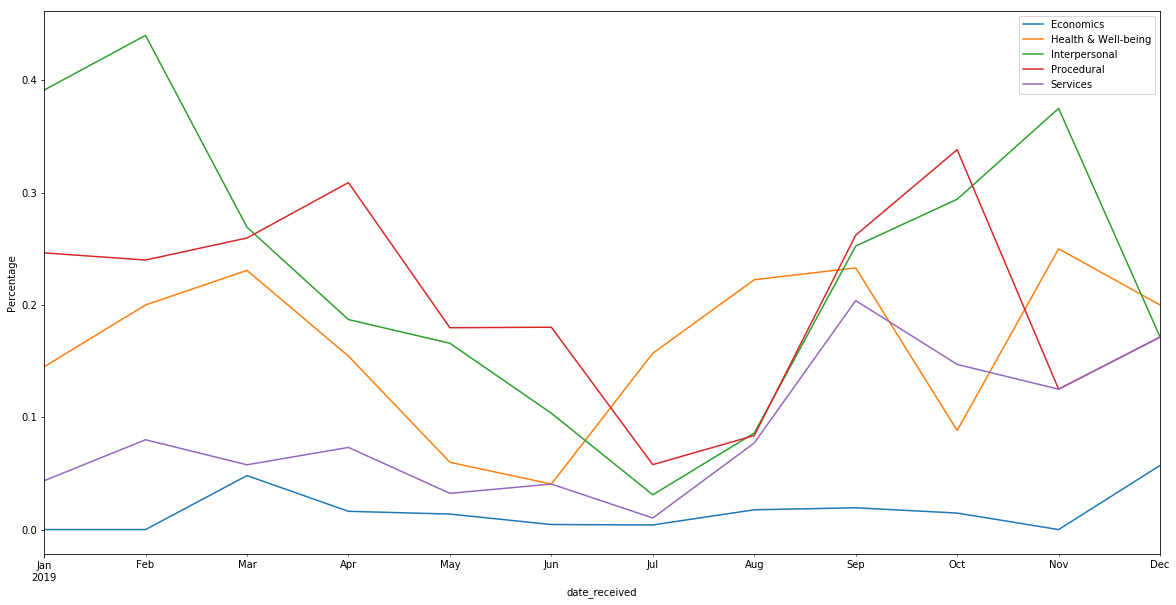

In [11]:
# Categories over time, 2019, normalized, excluding Operations
fig, ax = plt.subplots()
ax.set_ylabel('Percentage')
for key, data in df_cat[df_cat['name'] != 'Operations'].groupby('name'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))

In [12]:
# Flatten subtags
df_flat = pd.DataFrame([[i, x] for i, y in df['subtags'].apply(list).iteritems() for x in y],
                       columns=['I', 'subtags'])
df_flat = df_flat.set_index('I')
df_iss = df.drop('subtags', 1).merge(df_flat, left_index=True, right_index=True)

# Format for issues chart
df_iss.index = df_iss['date_received']
df_iss = (df_iss.groupby([pd.Grouper(freq='M'), 'subtags', 'name'])
                .count()
                .filter(['subtags', 'eid'])
                .rename(columns={'eid': 'count'})
                .reset_index()
         )
df_iss['subtags'] = list(zip(df_iss['subtags'], df_iss['name']))

# Pad zeroes
n_months = df_iss['date_received'].unique()
n_issues = df_iss['subtags'].unique()
n_idx = pd.MultiIndex.from_product((n_months, n_issues), names=['date_received', 'subtags'])
df_iss = df_iss.set_index(['date_received', 'subtags']).reindex(n_idx, fill_value=0).reset_index()

# Normalize
df_iss_sum = df_iss.groupby('date_received').sum()
df_iss_sum.columns = ['sum']
df_iss = df_iss.join(df_iss_sum, on='date_received')
df_iss['percentage'] = df_iss['count'] / df_iss['sum']

# Remove months with less than 5 entries
df_iss = df_iss[df_iss['sum'] >= 5]

# Reformat
df_iss[['subtags', 'name']] = pd.DataFrame(df_iss['subtags'].tolist(), index=df_iss.index)

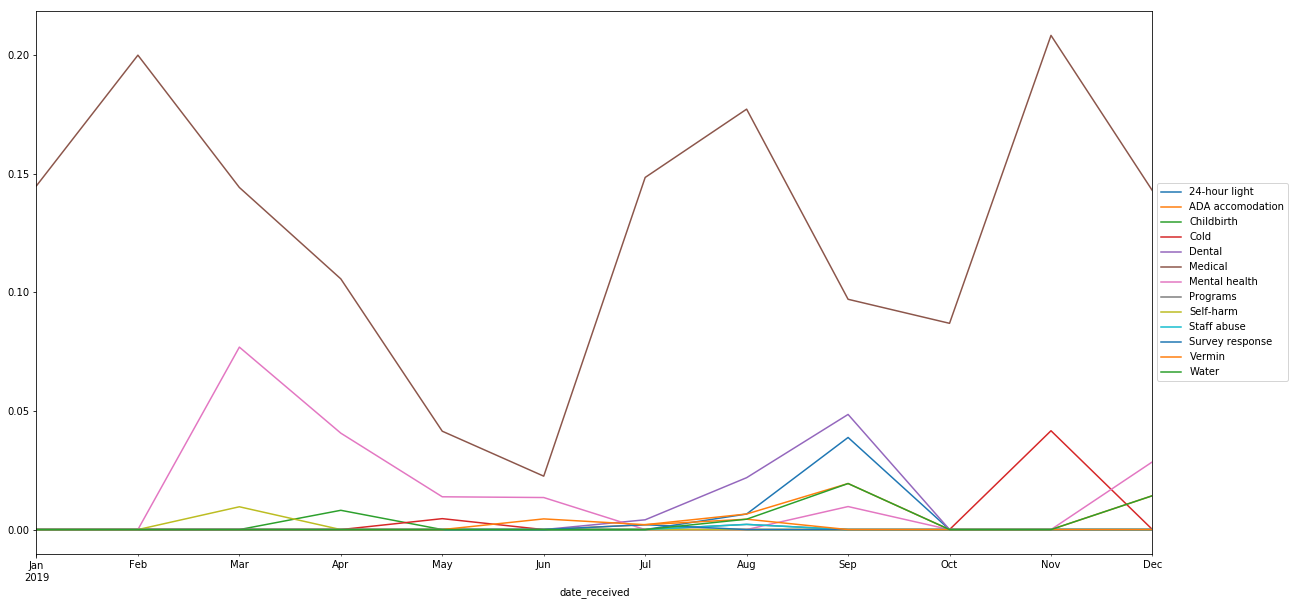

In [13]:
# Health & Well-being issues over time, 2019
fig, ax = plt.subplots()

for key, data in df_iss[df_iss['name'] == 'Health & Well-being'].groupby('subtags'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))
    
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

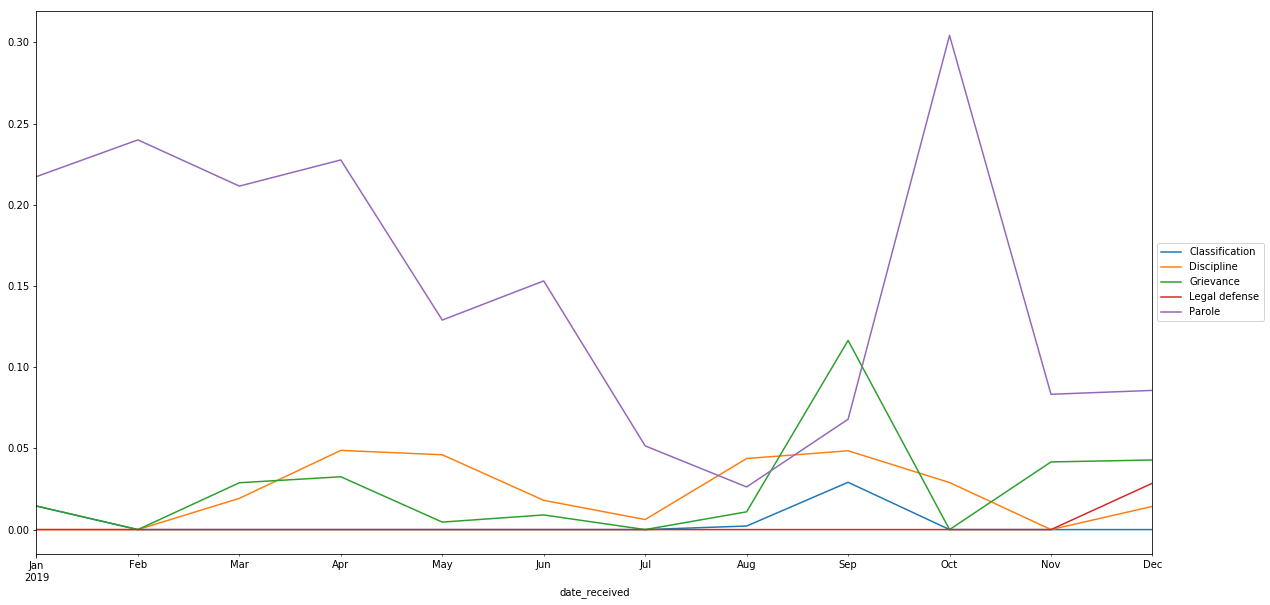

In [14]:
# Procedural issues over time, 2019
fig, ax = plt.subplots()
for key, data in df_iss[df_iss['name'] == 'Procedural'].groupby('subtags'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

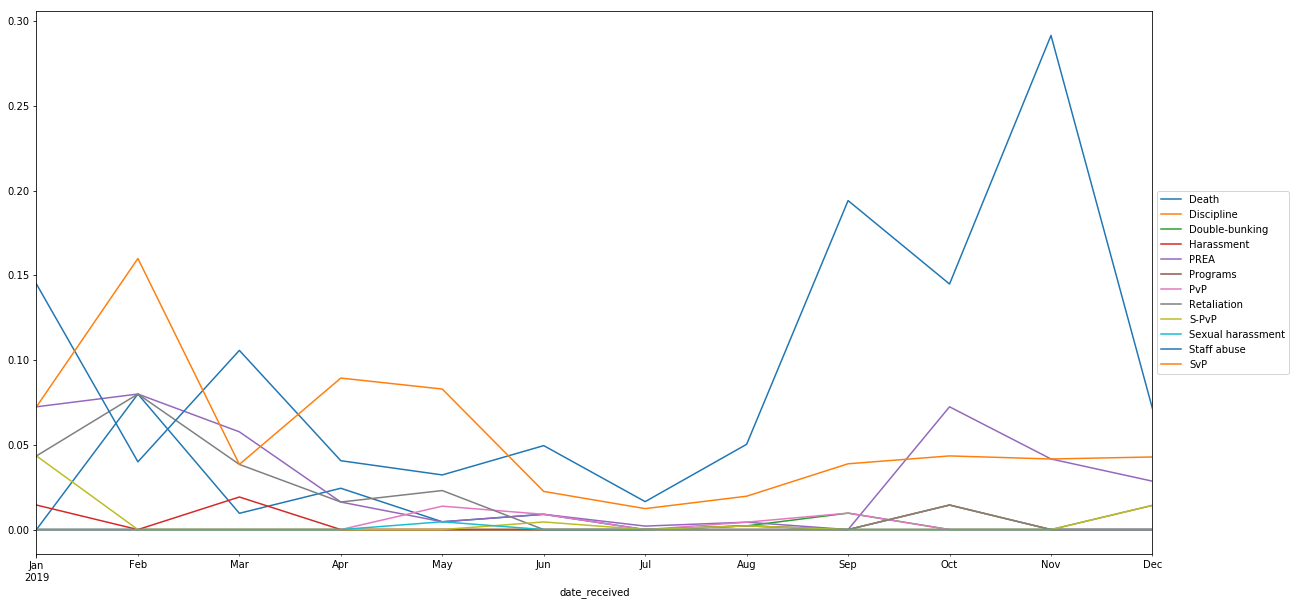

In [15]:
# Interpersonal issues over time, 2019
fig, ax = plt.subplots()
for key, data in df_iss[df_iss['name'] == 'Interpersonal'].groupby('subtags'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

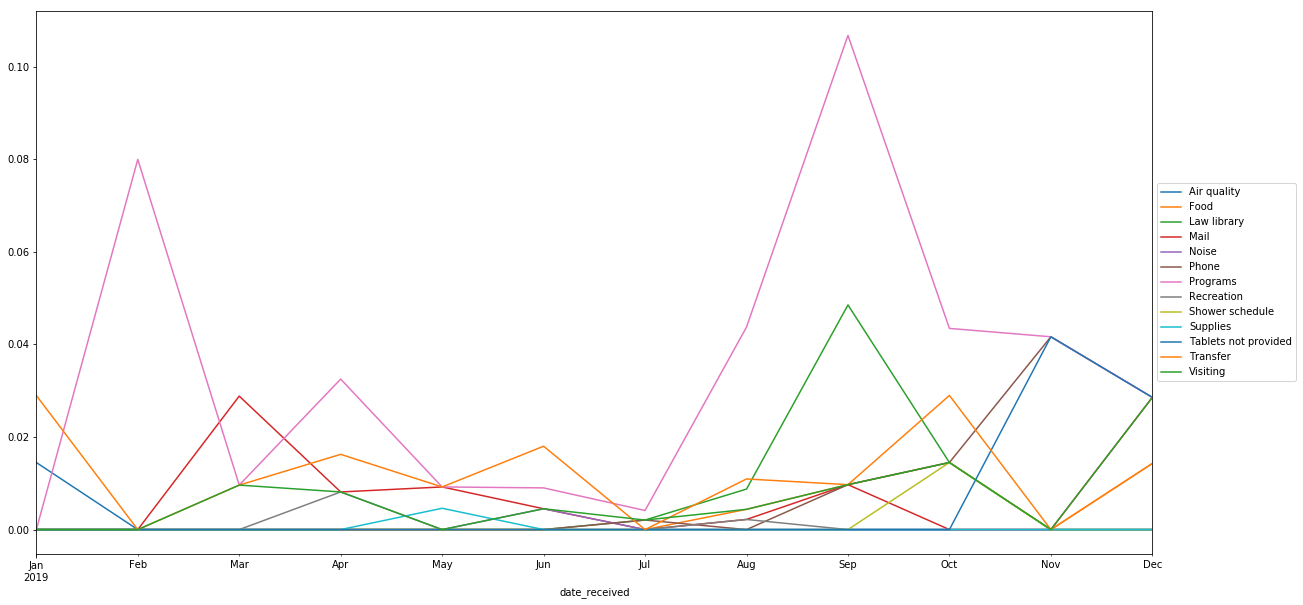

In [16]:
# Services issues over time, 2019
fig, ax = plt.subplots()
for key, data in df_iss[df_iss['name'] == 'Services'].groupby('subtags'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))